In [1]:
import tensorflow as tf
import keras

In [2]:
tf.__version__

'2.5.0'

In [3]:
keras.__version__

'2.5.0'

## 1. Data Preparation

### 1.1 Import data from .csv file

In [4]:
import pandas as pd
skill_builder_data = pd.read_csv('skill_builder_data_new.csv', encoding='utf-8')
skill_builder_data.head()

/Users/xrw/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,order_id,assignment_id,user_id,assistment_id,problem_id,original,correct,attempt_count,ms_first_response,tutor_mode,...,hint_count,hint_total,overlap_time,template_id,answer_id,answer_text,first_action,bottom_hint,opportunity,opportunity_original
0,33022537,277618,64525,33139,51424,1,1,1,32454,tutor,...,0,3,32454,30799,NaN,26,0,NaN,1,1.0
1,33022709,277618,64525,33150,51435,1,1,1,4922,tutor,...,0,3,4922,30799,NaN,55,0,NaN,2,2.0
2,35450204,220674,70363,33159,51444,1,0,2,25390,tutor,...,0,3,42000,30799,NaN,88,0,NaN,1,1.0
3,35450295,220674,70363,33110,51395,1,1,1,4859,tutor,...,0,3,4859,30059,NaN,41,0,NaN,2,2.0
4,35450311,220674,70363,33196,51481,1,0,14,19813,tutor,...,3,4,124564,30060,NaN,65,0,0.0,3,3.0


### 1.2 Data Preprocessing
Simple LSTM: using user_id, correct, skill_id

In [5]:
# 0. Feature selection and null-value filtering
simple_dataset = skill_builder_data[['user_id', 'correct', 'skill_id']]
simple_dataset.dropna(subset=['user_id', 'correct', 'skill_id'], inplace=True)

# 1. Enumerate skill id
simple_dataset['skill_id'], _ = pd.factorize(simple_dataset['skill_id'], sort=True)
simple_dataset['skill_id'] += 1
 
# 2. Build a synthetic feature skill_correct
simple_dataset['skill_with_answer'] = simple_dataset['skill_id']*2 + simple_dataset['correct']

# 3. Group by student_id
SEQ_LEN = 1000 # we only build model for students who answered no less than 100 questions
simple_dataset = simple_dataset.groupby('user_id').filter(lambda q: len(q) > SEQ_LEN).copy()

# 4. Convert to a sequence per user id and shift features 1 timestep 
# 3,4 cite: https://blog.csdn.net/sereasuesue/article/details/109890298?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522162787343116780264097163%2522%252C%2522scm%2522%253A%252220140713.130102334..%2522%257D&request_id=162787343116780264097163&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~sobaiduend~default-5-109890298.pc_search_result_control_group&utm_term=dkt&spm=1018.2226.3001.4187
simple_seq = simple_dataset.groupby('user_id').apply(
    lambda r: (
        r['skill_with_answer'].values[:-1],
    )
)
print(simple_seq)
print(simple_seq[53167])


/Users/xrw/opt/anaconda3/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
<ipython-input-5-61e654c3a61c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simple_dataset['skill_id'], _ = pd.factorize(simple_dataset['skill_id'], sort=True)
<ipython-input-5-61e654c3a61c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

user_id
71881    ([3, 3, 5, 4, 4, 4, 5, 4, 5, 5, 4, 5, 5, 5, 4,...
75169    ([3, 3, 3, 3, 5, 5, 4, 5, 4, 5, 4, 4, 5, 5, 5,...
77118    ([115, 115, 115, 115, 115, 115, 115, 115, 115,...
77899    ([8, 30, 30, 115, 115, 115, 115, 115, 115, 115...
78492    ([16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, ...
                               ...                        
92250    ([41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, ...
92251    ([41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, ...
96244    ([3, 3, 5, 5, 4, 4, 5, 5, 5, 4, 5, 5, 4, 4, 5,...
96265    ([2, 3, 2, 2, 2, 3, 3, 2, 2, 2, 3, 3, 4, 4, 4,...
96274    ([3, 3, 3, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4,...
Length: 67, dtype: object


KeyError: 53167

In [36]:
import numpy as np
n_timesteps = 10
features_set = {}
labels_set = {}
for i in range(len(simple_seq)):
    index = simple_seq.index[i]
    stu = simple_seq[index][0]
    features = []
    labels = []
    for i in range(n_timesteps, stu.shape[0]):
        features.append(stu[i-n_timesteps:i])
        labels.append(stu[i])
    
    features, labels = np.array(features), np.array(labels)
    labels_set[index] = labels
    features_set[index] = np.reshape(features,(features.shape[0], features.shape[1], 1))

print(features_set, labels_set)

{53167: array([[[ 11],
        [ 10],
        [ 11],
        ...,
        [ 14],
        [ 15],
        [ 15]],

       [[ 10],
        [ 11],
        [ 11],
        ...,
        [ 15],
        [ 15],
        [ 15]],

       [[ 11],
        [ 11],
        [ 10],
        ...,
        [ 15],
        [ 15],
        [ 15]],

       ...,

       [[201],
        [201],
        [201],
        ...,
        [200],
        [201],
        [201]],

       [[201],
        [201],
        [201],
        ...,
        [201],
        [201],
        [201]],

       [[201],
        [201],
        [200],
        ...,
        [201],
        [201],
        [201]]], dtype=int64), 64525: array([[[  3],
        [  3],
        [  5],
        ...,
        [  5],
        [  5],
        [  4]],

       [[  3],
        [  5],
        [  5],
        ...,
        [  5],
        [  4],
        [  5]],

       [[  5],
        [  5],
        [  5],
        ...,
        [  4],
        [  5],
        [  5]],

       ...,



### 1.3 Split training, validation and test datasets.

In [37]:
from sklearn.model_selection import train_test_split

x_train = {}
x_validation = {}
y_train = {}
y_validation = {}
scaler = max(simple_dataset['skill_with_answer'].unique())

for i in range(len(simple_seq)):
    index = simple_seq.index[i]
    x_train[index], x_validation[index] = train_test_split(features_set[index], test_size=0.2, shuffle=False)
    y_train[index], y_validation[index] = train_test_split(labels_set[index], test_size=0.2, shuffle=False)
    
print(x_validation[53167], y_validation[53167])

[[[164]
  [165]
  [165]
  [165]
  [165]
  [165]
  [165]
  [166]
  [167]
  [166]]

 [[165]
  [165]
  [165]
  [165]
  [165]
  [165]
  [166]
  [167]
  [166]
  [166]]

 [[165]
  [165]
  [165]
  [165]
  [165]
  [166]
  [167]
  [166]
  [166]
  [167]]

 [[165]
  [165]
  [165]
  [165]
  [166]
  [167]
  [166]
  [166]
  [167]
  [167]]

 [[165]
  [165]
  [165]
  [166]
  [167]
  [166]
  [166]
  [167]
  [167]
  [167]]

 [[165]
  [165]
  [166]
  [167]
  [166]
  [166]
  [167]
  [167]
  [167]
  [167]]

 [[165]
  [166]
  [167]
  [166]
  [166]
  [167]
  [167]
  [167]
  [167]
  [167]]

 [[166]
  [167]
  [166]
  [166]
  [167]
  [167]
  [167]
  [167]
  [167]
  [167]]

 [[167]
  [166]
  [166]
  [167]
  [167]
  [167]
  [167]
  [167]
  [167]
  [186]]

 [[166]
  [166]
  [167]
  [167]
  [167]
  [167]
  [167]
  [167]
  [186]
  [187]]

 [[166]
  [167]
  [167]
  [167]
  [167]
  [167]
  [167]
  [186]
  [187]
  [187]]

 [[167]
  [167]
  [167]
  [167]
  [167]
  [167]
  [186]
  [187]
  [187]
  [187]]

 [[167]
  [167]


## 2. Modeling

In [38]:
from keras import layers
from keras import models

n_features = 1

model = models.Sequential()
model.add(layers.LSTM(1000, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(layers.Dense(1, activation='linear'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1000)              4008000   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1001      
Total params: 4,009,001
Trainable params: 4,009,001
Non-trainable params: 0
_________________________________________________________________


## 3. Training

In [48]:
nepochs = 50
model.compile(optimizer='Adagrad', 
              loss='mse')
history = model.fit(x_train[53167], y_train[53167],
          epochs=nepochs,
          batch_size=32,
          validation_data=(x_validation[53167], y_validation[53167]))
history = history.history

Epoch 1/50
8/8 [==============================] - 2s 162ms/step - loss: 1988.0225 - val_loss: 158.6920
Epoch 2/50
8/8 [==============================] - 1s 105ms/step - loss: 32.1835 - val_loss: 30.6933
Epoch 3/50
8/8 [==============================] - 1s 105ms/step - loss: 26.2853 - val_loss: 31.3241
Epoch 4/50
8/8 [==============================] - 1s 106ms/step - loss: 19.2912 - val_loss: 42.7340
Epoch 5/50
8/8 [==============================] - 1s 105ms/step - loss: 16.6172 - val_loss: 23.2985
Epoch 6/50
8/8 [==============================] - 1s 105ms/step - loss: 10.7954 - val_loss: 25.2178
Epoch 7/50
8/8 [==============================] - 1s 104ms/step - loss: 17.4585 - val_loss: 40.2814
Epoch 8/50
8/8 [==============================] - 1s 105ms/step - loss: 12.4746 - val_loss: 113.2725
Epoch 9/50
8/8 [==============================] - 1s 104ms/step - loss: 15.5753 - val_loss: 43.4950
Epoch 10/50
8/8 [==============================] - 1s 107ms/step - loss: 9.2682 - val_loss: 44.6

## 4. Plot the result

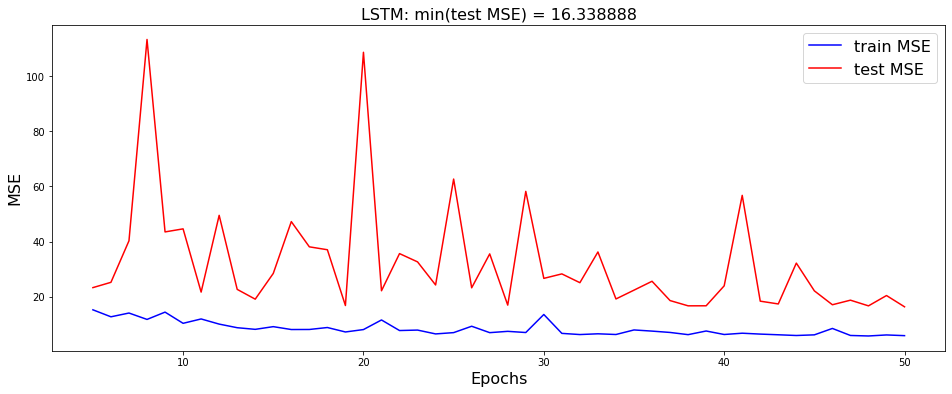

In [49]:
import matplotlib.pyplot as plt

train_mse = history['loss']
test_mse = history['val_loss']

plt.figure(figsize=(16,6))
plt.plot(range(5,nepochs+1), train_mse[4:], 'b', label='train MSE',color="blue")
plt.plot(range(5,nepochs+1), test_mse[4:], 'b', label='test MSE',color="red")

#plt.ylim((0, 0.0001))
plt.title('LSTM: min(test MSE) = ' + str(round(min(test_mse),6)),fontsize=16)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('MSE',fontsize=16)
plt.legend(loc = 'upper right',fontsize=16)
#plt.ylim(0,0.001)

plt.show()

[[ 13.066379 ]
 [ 13.610864 ]
 [ 14.4246435]
 [ 15.066136 ]
 [ 15.759002 ]
 [ 16.55463  ]
 [ 16.53201  ]
 [ 16.486319 ]
 [ 16.657085 ]
 [ 16.5665   ]
 [ 16.56641  ]
 [ 16.533573 ]
 [ 16.92537  ]
 [ 17.76438  ]
 [ 18.507103 ]
 [ 19.557114 ]
 [ 20.09357  ]
 [ 20.826317 ]
 [ 21.823605 ]
 [ 23.232658 ]
 [ 24.504288 ]
 [ 25.712685 ]
 [ 26.5181   ]
 [ 26.97573  ]
 [ 27.649418 ]
 [ 28.14676  ]
 [ 28.73845  ]
 [ 29.161514 ]
 [ 30.325987 ]
 [ 31.549725 ]
 [ 32.895187 ]
 [ 34.807137 ]
 [ 36.3672   ]
 [ 37.69274  ]
 [ 38.64377  ]
 [ 39.802677 ]
 [ 41.039234 ]
 [ 42.307938 ]
 [ 43.555584 ]
 [ 45.131386 ]
 [ 46.649593 ]
 [ 47.408276 ]
 [ 47.907104 ]
 [ 48.2615   ]
 [ 48.794224 ]
 [ 49.236206 ]
 [ 49.67848  ]
 [ 51.214775 ]
 [ 52.319374 ]
 [ 53.10104  ]
 [ 53.681538 ]
 [ 53.83464  ]
 [ 54.424377 ]
 [ 55.202976 ]
 [ 55.601685 ]
 [ 56.10737  ]
 [ 56.556995 ]
 [ 56.483818 ]
 [ 58.168842 ]
 [ 59.639812 ]
 [ 60.37119  ]
 [ 60.682037 ]
 [ 61.11171  ]
 [ 61.477173 ]
 [ 61.829834 ]
 [ 62.074303 ]
 [ 62.3157

<Figure size 432x288 with 0 Axes>

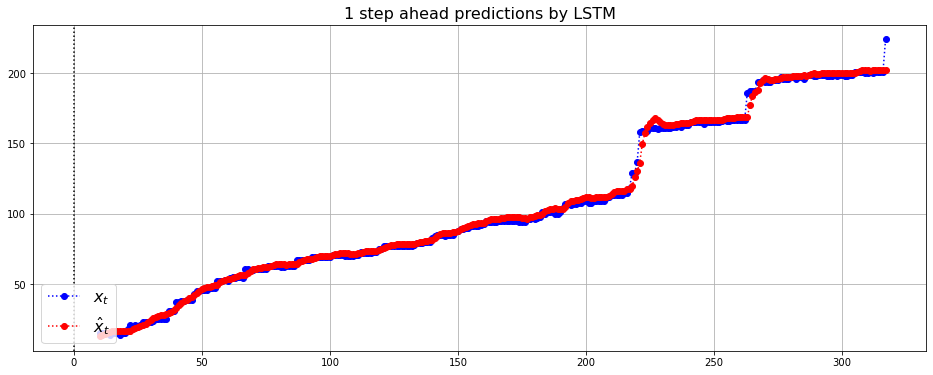

In [50]:
plt.clf()   # clear figure
xhat = model.predict(features_set[53167])
print(xhat)

plt.figure(figsize=(16,6))
plt.title("1 step ahead predictions by LSTM",fontsize=16)

plt.axvline(x=len(simple_seq[53167])-1,linestyle=':',color='k')
plt.plot(range(10,len(simple_seq[53167][0])),simple_seq[53167][0][10:], linestyle=':', marker='o',color='blue',label = "$x_t$")
plt.plot(range(10,len(simple_seq[53167][0])),xhat, linestyle=':', marker='o',color='red',label = "$\hat{x}_t$")

plt.grid(True)
plt.legend(loc = 'lower left',fontsize=16)
plt.show()

## 5. Optimizing

In [26]:
# 5.1 one-hot encoding
from tensorflow.python.keras.utils.np_utils import to_categorical
num_of_skills = np.max(simple_dataset['skill_with_answer'])+1
x_train_1, x_validation_1 = x_train.copy(), x_validation.copy()
y_train_1, y_validation_1 = y_train.copy(), y_validation.copy()
print(x_train_1[53167])
print(x_validation_1[53167])
x_train_1[53167]=to_categorical(x_train_1[53167], num_of_skills)
x_validation_1[53167]=to_categorical(x_validation_1[53167], num_of_skills)

[[[ 11]
  [ 10]
  [ 11]
  ...
  [ 14]
  [ 15]
  [ 15]]

 [[ 10]
  [ 11]
  [ 11]
  ...
  [ 15]
  [ 15]
  [ 15]]

 [[ 11]
  [ 11]
  [ 10]
  ...
  [ 15]
  [ 15]
  [ 15]]

 ...

 [[165]
  [165]
  [165]
  ...
  [165]
  [165]
  [165]]

 [[165]
  [165]
  [164]
  ...
  [165]
  [165]
  [166]]

 [[165]
  [164]
  [165]
  ...
  [165]
  [166]
  [167]]]
[[[164]
  [165]
  [165]
  [165]
  [165]
  [165]
  [165]
  [166]
  [167]
  [166]]

 [[165]
  [165]
  [165]
  [165]
  [165]
  [165]
  [166]
  [167]
  [166]
  [166]]

 [[165]
  [165]
  [165]
  [165]
  [165]
  [166]
  [167]
  [166]
  [166]
  [167]]

 [[165]
  [165]
  [165]
  [165]
  [166]
  [167]
  [166]
  [166]
  [167]
  [167]]

 [[165]
  [165]
  [165]
  [166]
  [167]
  [166]
  [166]
  [167]
  [167]
  [167]]

 [[165]
  [165]
  [166]
  [167]
  [166]
  [166]
  [167]
  [167]
  [167]
  [167]]

 [[165]
  [166]
  [167]
  [166]
  [166]
  [167]
  [167]
  [167]
  [167]
  [167]]

 [[166]
  [167]
  [166]
  [166]
  [167]
  [167]
  [167]
  [167]
  [167]
  [167]]

 [

In [27]:
print(x_train_1[53167])
print(x_validation_1[53167])

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
[[[0. 0. 0

In [28]:
n_features = len(x_train_1[53167])+2

model = models.Sequential()
model.add(layers.LSTM(1000, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(layers.Dense(1, activation='linear'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1000)              4996000   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1001      
Total params: 4,997,001
Trainable params: 4,997,001
Non-trainable params: 0
_________________________________________________________________


In [29]:
print(x_train_1[53167].shape, x_validation_1[53167].shape)

(246, 10, 248) (62, 10, 248)


In [30]:
model.compile(optimizer='Adagrad', 
              loss='mse')
history = model.fit(x_train_1[53167], y_train_1[53167],
          epochs=nepochs,
          batch_size=32,
          validation_data=(x_validation_1[53167], y_validation_1[53167]))
history = history.history

Epoch 1/50
8/8 [==============================] - 3s 182ms/step - loss: 9068.9988 - val_loss: 37695.2031
Epoch 2/50
8/8 [==============================] - 1s 122ms/step - loss: 9050.4510 - val_loss: 33353.2773
Epoch 3/50
8/8 [==============================] - 1s 121ms/step - loss: 4923.9847 - val_loss: 28361.9180
Epoch 4/50
8/8 [==============================] - 1s 121ms/step - loss: 1900.4357 - val_loss: 28171.5879
Epoch 5/50
8/8 [==============================] - 1s 120ms/step - loss: 1234.6129 - val_loss: 20224.4238
Epoch 6/50
8/8 [==============================] - 1s 122ms/step - loss: 217.2930 - val_loss: 21260.4258
Epoch 7/50
8/8 [==============================] - 1s 121ms/step - loss: 158.9545 - val_loss: 21416.5527
Epoch 8/50
8/8 [==============================] - 1s 121ms/step - loss: 95.8033 - val_loss: 20573.8516
Epoch 9/50
8/8 [==============================] - 1s 121ms/step - loss: 140.5089 - val_loss: 22319.2852
Epoch 10/50
8/8 [==============================] - 1s 119ms/

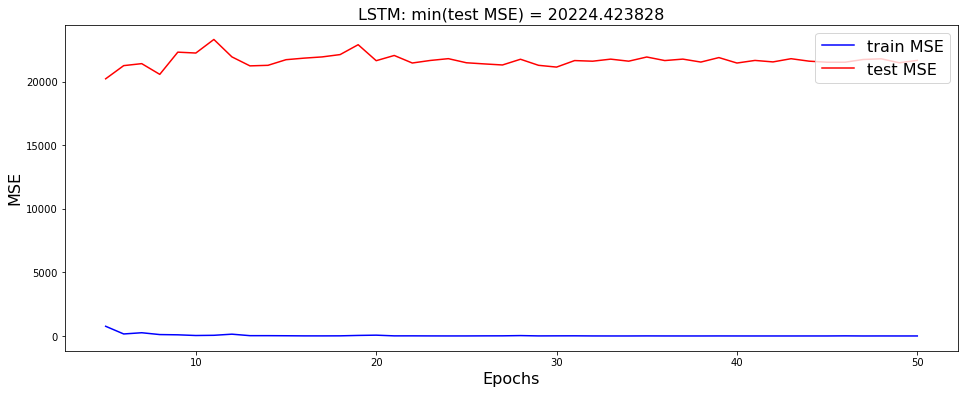

[[ 14.5834465]
 [ 14.59881  ]
 [ 15.389679 ]
 [ 15.835619 ]
 [ 16.755243 ]
 [ 18.68271  ]
 [ 18.31959  ]
 [ 18.006464 ]
 [ 19.609165 ]
 [ 19.468792 ]
 [ 19.272833 ]
 [ 18.966387 ]
 [ 18.628746 ]
 [ 18.262861 ]
 [ 17.922918 ]
 [ 19.525793 ]
 [ 19.494856 ]
 [ 19.612028 ]
 [ 20.048857 ]
 [ 22.958033 ]
 [ 24.200003 ]
 [ 25.818441 ]
 [ 23.366924 ]
 [ 23.583796 ]
 [ 24.52191  ]
 [ 25.525167 ]
 [ 27.490662 ]
 [ 29.818293 ]
 [ 30.627768 ]
 [ 31.950468 ]
 [ 34.277176 ]
 [ 36.468765 ]
 [ 37.42715  ]
 [ 37.73461  ]
 [ 38.21831  ]
 [ 38.984848 ]
 [ 40.166016 ]
 [ 42.191364 ]
 [ 43.34458  ]
 [ 44.69499  ]
 [ 45.925785 ]
 [ 45.306107 ]
 [ 45.38795  ]
 [ 46.173634 ]
 [ 46.711155 ]
 [ 47.727863 ]
 [ 49.742664 ]
 [ 51.226585 ]
 [ 51.92507  ]
 [ 52.251354 ]
 [ 52.49531  ]
 [ 52.78307  ]
 [ 53.149055 ]
 [ 53.786465 ]
 [ 53.911037 ]
 [ 54.567833 ]
 [ 56.364258 ]
 [ 57.59247  ]
 [ 58.863983 ]
 [ 59.908363 ]
 [ 59.639812 ]
 [ 60.753475 ]
 [ 60.058933 ]
 [ 60.503056 ]
 [ 59.736877 ]
 [ 61.41096  ]
 [ 62.2838

<Figure size 432x288 with 0 Axes>

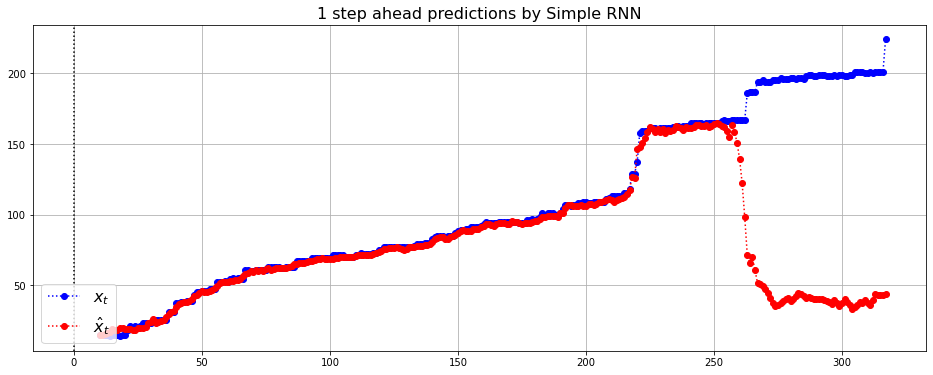

In [31]:
import matplotlib.pyplot as plt

train_mse = history['loss']
test_mse = history['val_loss']

plt.figure(figsize=(16,6))
plt.plot(range(5,nepochs+1), train_mse[4:], 'b', label='train MSE',color="blue")
plt.plot(range(5,nepochs+1), test_mse[4:], 'b', label='test MSE',color="red")

#plt.ylim((0, 0.0001))
plt.title('LSTM: min(test MSE) = ' + str(round(min(test_mse),6)),fontsize=16)
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('MSE',fontsize=16)
plt.legend(loc = 'upper right',fontsize=16)
#plt.ylim(0,0.001)

plt.show()
plt.clf()   # clear figure
xhat = model.predict(to_categorical(features_set[53167], num_of_skills))
print(xhat)

plt.figure(figsize=(16,6))
plt.title("1 step ahead predictions by Simple RNN",fontsize=16)

plt.axvline(x=len(simple_seq[53167])-1,linestyle=':',color='k')
plt.plot(range(10,len(simple_seq[53167][0])),simple_seq[53167][0][10:], linestyle=':', marker='o',color='blue',label = "$x_t$")
plt.plot(range(10,len(simple_seq[53167][0])),xhat, linestyle=':', marker='o',color='red',label = "$\hat{x}_t$")

plt.grid(True)
plt.legend(loc = 'lower left',fontsize=16)
plt.show()